In [1]:
import os
import argparse
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn        #for all Neural Network stuff
import torch.optim as optim  #for all optimizer stuff

In [2]:
#method argument not needed??
data_size = 1000 #number of points in linspace
batch_time = 20 #number of points in the interval after a random starting point
batch_size = 500 #number of intervals
niters = 2000 #number of iterations
test_freq = 10
viz = True
gpu = 1
adjoint = True

In [3]:
from torchdiffeq import odeint_adjoint as odeint

In [4]:
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

In [5]:
#create linspace like usual
t = torch.linspace(0.0, 25.0, data_size)
#creates a system of differential equations for dy and dx
true_A = torch.tensor([[-0.1,2.0],[-2.0, -0.1]]) # will generate 2 right hand side second order DE's

In [6]:
def random():
    rand = 0
    while abs(rand) < 1 or abs(rand) > 3:
        rand = np.random.normal(0, 1, 1)[0]
    return rand

In [7]:
def getSlopesTorch(x1,x2,function):
    dim =  x1.shape[0] * x2.shape[0]
    slopeList = torch.zeros((dim,2))
    i = 0
    for l in x1:
        for k in x2:
            #print(slope([],[l,k]))
            slopeList[i] = function.forward([],torch.tensor([[l,k]]))
            i += 1
    return slopeList

In [8]:
#lambda is a nn.Module like Linear, Conv2D etc,,
class Lambda(nn.Module):
    def forward(self,t,y):
        return torch.mm(y**3,true_A) #< is the same as below
        #return torch.tensor([-0.1*y[:,0]**3-2*y[:,1]**3,2*y[:,0]**3-0.1*y[:,1]**3])  #starting with true_y0 it does mxn X nxp -> mxp

In [9]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size-batch_time, dtype=np.int64), batch_size, replace=False))
#s is a torch tensor from a numpy array. the array is a random choice array, a rand number from 0 to ds-bt is chosen bs times.
#s has batch_size elements and each was equally likely to be chosen
#why ds-bt? why not just data_size as a rance since we are chosing from the t linspace with ds many points?
#it does ds-bt so that when it chooses the next bt number of points we will never fall out of the index range if
#    ds=1000 and bt=10 then then if i start at 990, I will end up with 990-1000 and not over.
    batch_y0 = true_y[s] #(M, D) <- idk what this means
#b_y0 is made of the randomly selected data points (dep vals) from true_y solution
    batch_t = t[:batch_time] #(T)
#b_t is the values rank 0 to b_time from your linspace t; the linspace values being looked at
    batch_y = torch.stack([true_y[s+i] for i in range(batch_time)],dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y


In [10]:
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

In [11]:
def drawDFT(ySpace, length, function):
    for l in ySpace:
        for k in ySpace:
            y = torch.tensor([[l,k]])
            t = torch.tensor([[]])
            #direction i and j + Magnitude of <i,j>
            i = function.forward(t,y)[:,0][0].numpy()
            j = function.forward(t,y)[:,1][0].numpy()
            magnitude = np.sqrt(i**2+j**2)
            
            #normalize and scale by h
            i = h*i/magnitude
            j = h*j/magnitude
            
            current_domain = np.linspace(l-(i/2), l+(i/2), 2) #the end points of the small intervals
            current_range = np.linspace(k-(j/2), k+(j/2), 2)

            plt.plot(current_domain, current_range, lw=0.2, color='b')
            plt.arrow(current_domain[0],current_range[0], i, j, color='b', lw=0.5, length_includes_head=True, head_length=0.1, head_width=0.1)

In [12]:
def visualize(true_y, pred_y, y_space, length, function):
    b = y_space[y_space.size-1]
    a = y_space[0]
    
    #Draw True Y
    drawDFT(y_space, length, Lambda())
    plt.plot(true_y.numpy()[:, 0, 0], true_y.numpy()[:, 0, 1],'r--')
    plt.xlim(a,b)
    plt.ylim(a,b)
    plt.savefig('png/{:03d}'.format(itr))
    plt.show()
    
    #Draw Pred Y
    drawDFT(y_space, length, function)
    plt.plot(pred_y.numpy()[:, 0, 0], pred_y.numpy()[:, 0, 1],'m--')
    plt.xlim(a,b)
    plt.ylim(a,b)
    plt.savefig('png/{:03d}'.format(itr))
    plt.show()

In [13]:
class ODEFunc(nn.Module): #create an ODE block as our neural network. usually multiple layers/modules
    
    def __init__(self):
        super(ODEFunc, self).__init__()
#self.net is the neural network layers one after the other L -> T -> L        
        self.net = nn.Sequential(    
            nn.Linear(2,50),
            nn.Tanh(),
            nn.Linear(50,2),
        )
        
        for m in self.net.modules():
            if isinstance(m,nn.Linear): #checks in the module m in self.net is an instance of the nn.Linear class
                nn.init.normal_(m.weight, mean=0, std=0.1) #for the Linear modules make all the weights randn with std 0.1
                nn.init.constant_(m.bias, val=0) #for the Linear modules make all the bias vector values 0
    
    def forward(self, t, y):
        return self.net(y**3) #essentially Lambda.forward(args) without the true_A >>>which is TBD<<<

In [ ]:
# class RunningAverageMeter(object): #Computes and stores the average and current value
    def __init__(self, momentum=0.99): #new object of this class will have mom of 0.99 and a reset val and avg
        self.momentum = momentum
        self.reset()
    def reset(self):                   #reset function called to set val and avg to None and 0 respectively
        self.val = None
        self.avg = 0
    def update(self, val):             #update is called externally to update the avg based on val
        if self.val is None:
            self.avg = val
        else:
            self.avg = (self.avg * self.momentum) + (val * (1 - self.momentum)) #reminds me of output error at L

Iteration 0001 | Total Loss 372.779236
Iteration 0002 | Total Loss 308.946289
Iteration 0003 | Total Loss 269.608734
Iteration 0004 | Total Loss 238.570129
Iteration 0005 | Total Loss 213.654800
Iteration 0006 | Total Loss 193.444946
Iteration 0007 | Total Loss 176.996521
Iteration 0008 | Total Loss 163.434845
Iteration 0009 | Total Loss 152.097015
Iteration 0010 | Total Loss 142.456009


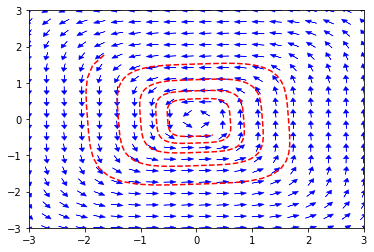

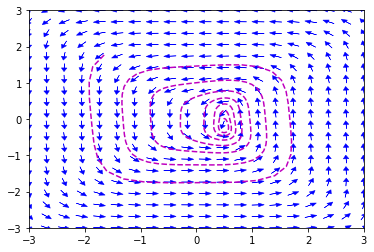

Iteration 0011 | Total Loss 134.126205
Iteration 0012 | Total Loss 126.820564
Iteration 0013 | Total Loss 120.331413
Iteration 0014 | Total Loss 114.889015
Iteration 0015 | Total Loss 110.953140
Iteration 0016 | Total Loss 107.987999
Iteration 0017 | Total Loss 104.153450
Iteration 0018 | Total Loss 99.256874
Iteration 0019 | Total Loss 94.624107
Iteration 0020 | Total Loss 90.827301


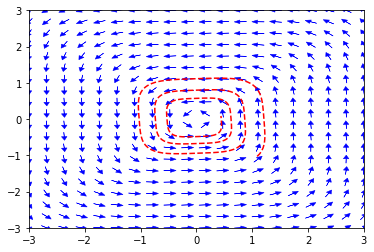

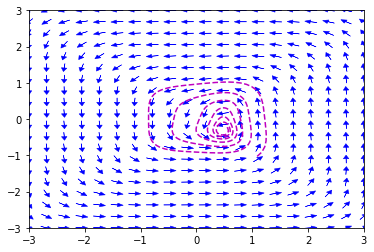

Iteration 0021 | Total Loss 88.152092
Iteration 0022 | Total Loss 87.164154
Iteration 0023 | Total Loss 87.071739
Iteration 0024 | Total Loss 84.799759
Iteration 0025 | Total Loss 80.574020
Iteration 0026 | Total Loss 76.641579
Iteration 0027 | Total Loss 73.318527
Iteration 0028 | Total Loss 70.793663
Iteration 0029 | Total Loss 68.967552
Iteration 0030 | Total Loss 67.815315


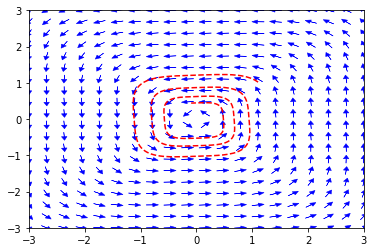

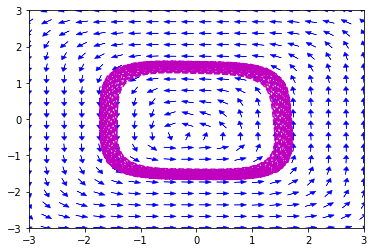

Iteration 0031 | Total Loss 67.214699
Iteration 0032 | Total Loss 68.027916
Iteration 0033 | Total Loss 70.637154
Iteration 0034 | Total Loss 67.256027
Iteration 0035 | Total Loss 60.422413
Iteration 0036 | Total Loss 56.505463
Iteration 0037 | Total Loss 54.361069
Iteration 0038 | Total Loss 52.782314
Iteration 0039 | Total Loss 51.777302
Iteration 0040 | Total Loss 52.046791


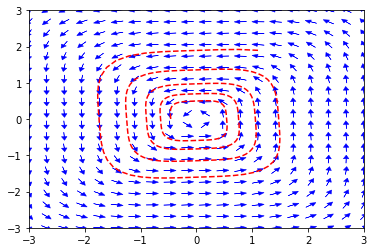

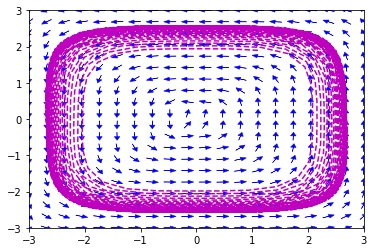

Iteration 0041 | Total Loss 54.573986
Iteration 0042 | Total Loss 55.798008
Iteration 0043 | Total Loss 52.791725
Iteration 0044 | Total Loss 51.342815
Iteration 0045 | Total Loss 52.859318
Iteration 0046 | Total Loss 51.001167
Iteration 0047 | Total Loss 46.520042
Iteration 0048 | Total Loss 43.366211
Iteration 0049 | Total Loss 41.746883
Iteration 0050 | Total Loss 40.567722


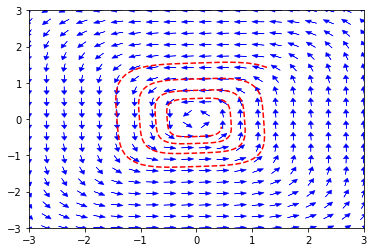

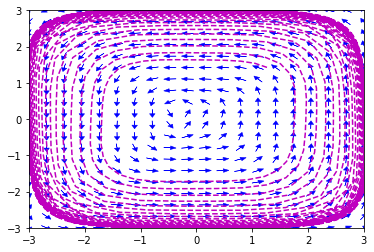

Iteration 0051 | Total Loss 39.604752
Iteration 0052 | Total Loss 38.722672
Iteration 0053 | Total Loss 37.949200
Iteration 0054 | Total Loss 37.235382
Iteration 0055 | Total Loss 36.627514
Iteration 0056 | Total Loss 36.060955
Iteration 0057 | Total Loss 35.565437
Iteration 0058 | Total Loss 35.010384
Iteration 0059 | Total Loss 34.432636
Iteration 0060 | Total Loss 33.695236


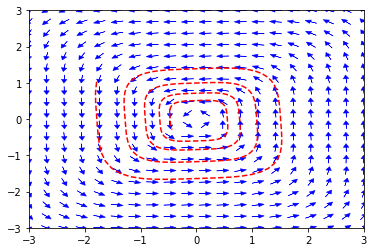

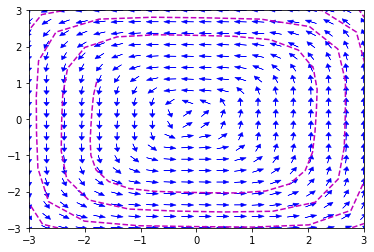

Iteration 0061 | Total Loss 32.925457
Iteration 0062 | Total Loss 32.047878
Iteration 0063 | Total Loss 31.211084
Iteration 0064 | Total Loss 30.354044
Iteration 0065 | Total Loss 29.571331
Iteration 0066 | Total Loss 28.805790
Iteration 0067 | Total Loss 28.111366
Iteration 0068 | Total Loss 27.441841
Iteration 0069 | Total Loss 26.831352
Iteration 0070 | Total Loss 26.244049


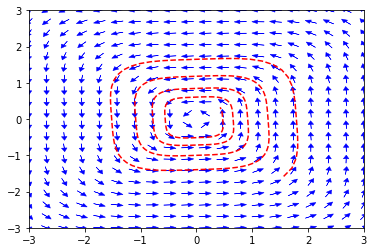

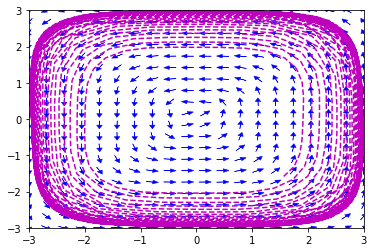

Iteration 0071 | Total Loss 25.705170
Iteration 0072 | Total Loss 25.185732
Iteration 0073 | Total Loss 24.707222
Iteration 0074 | Total Loss 24.244154
Iteration 0075 | Total Loss 23.816866
Iteration 0076 | Total Loss 23.400677
Iteration 0077 | Total Loss 23.016338
Iteration 0078 | Total Loss 22.637928
Iteration 0079 | Total Loss 22.287811
Iteration 0080 | Total Loss 21.937426


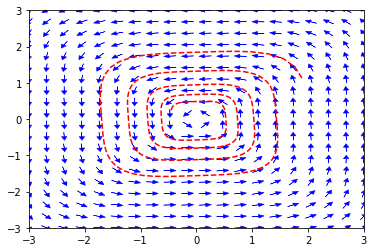

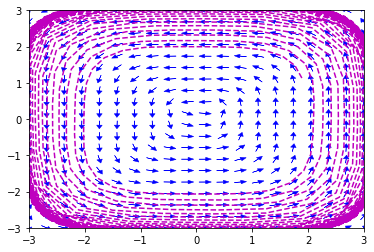

Iteration 0081 | Total Loss 21.611895
Iteration 0082 | Total Loss 21.279305
Iteration 0083 | Total Loss 20.968678
Iteration 0084 | Total Loss 20.644716
Iteration 0085 | Total Loss 20.341242
Iteration 0086 | Total Loss 20.020071
Iteration 0087 | Total Loss 19.719881
Iteration 0088 | Total Loss 19.400236
Iteration 0089 | Total Loss 19.103861
Iteration 0090 | Total Loss 18.788557


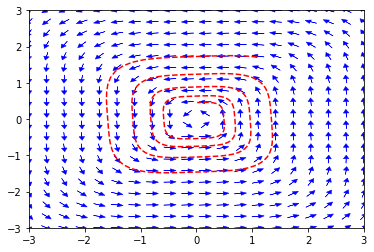

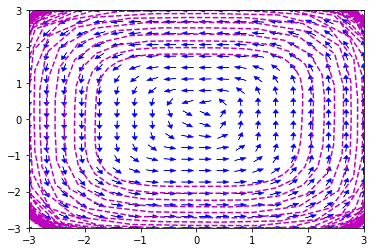

Iteration 0091 | Total Loss 18.499693
Iteration 0092 | Total Loss 18.193619
Iteration 0093 | Total Loss 17.917053
Iteration 0094 | Total Loss 17.625061
Iteration 0095 | Total Loss 17.364996
Iteration 0096 | Total Loss 17.090616
Iteration 0097 | Total Loss 16.849867
Iteration 0098 | Total Loss 16.594893
Iteration 0099 | Total Loss 16.374788
Iteration 0100 | Total Loss 16.139458


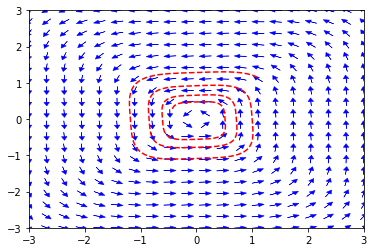

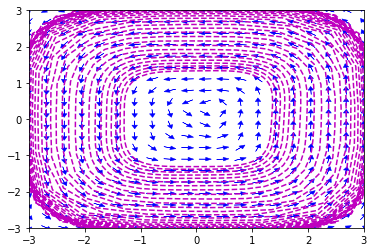

Iteration 0101 | Total Loss 15.940033
Iteration 0102 | Total Loss 15.723258
Iteration 0103 | Total Loss 15.543461
Iteration 0104 | Total Loss 15.343065
Iteration 0105 | Total Loss 15.180870
Iteration 0106 | Total Loss 14.993715
Iteration 0107 | Total Loss 14.846181
Iteration 0108 | Total Loss 14.668365
Iteration 0109 | Total Loss 14.531833
Iteration 0110 | Total Loss 14.359047


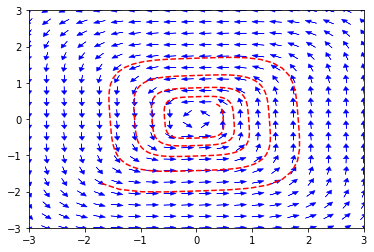

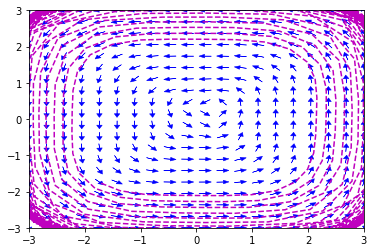

Iteration 0111 | Total Loss 14.229509
Iteration 0112 | Total Loss 14.057681
Iteration 0113 | Total Loss 13.931435
Iteration 0114 | Total Loss 13.757484
Iteration 0115 | Total Loss 13.631804
Iteration 0116 | Total Loss 13.454236
Iteration 0117 | Total Loss 13.327866
Iteration 0118 | Total Loss 13.146967
Iteration 0119 | Total Loss 13.020164
Iteration 0120 | Total Loss 12.837636


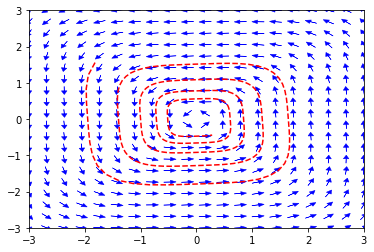

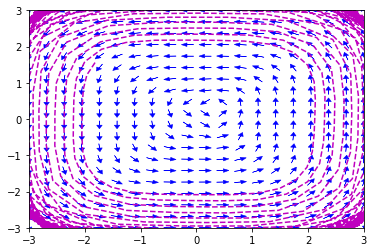

Iteration 0121 | Total Loss 12.711785
Iteration 0122 | Total Loss 12.530075
Iteration 0123 | Total Loss 12.407089
Iteration 0124 | Total Loss 12.228641
Iteration 0125 | Total Loss 12.110389
Iteration 0126 | Total Loss 11.937129
Iteration 0127 | Total Loss 11.825057
Iteration 0128 | Total Loss 11.658132
Iteration 0129 | Total Loss 11.553084
Iteration 0130 | Total Loss 11.392830


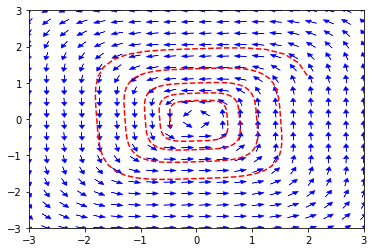

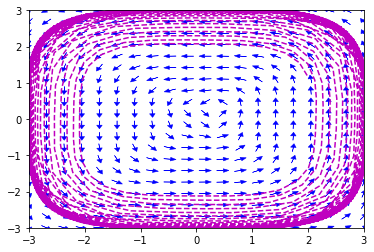

Iteration 0131 | Total Loss 11.295028
Iteration 0132 | Total Loss 11.141092
Iteration 0133 | Total Loss 11.050189
Iteration 0134 | Total Loss 10.901701
Iteration 0135 | Total Loss 10.816892
Iteration 0136 | Total Loss 10.672648
Iteration 0137 | Total Loss 10.592803
Iteration 0138 | Total Loss 10.451485
Iteration 0139 | Total Loss 10.375294
Iteration 0140 | Total Loss 10.235674


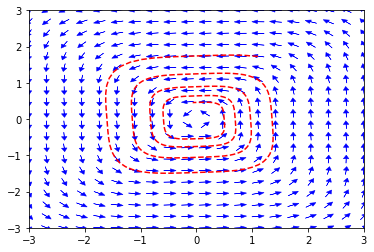

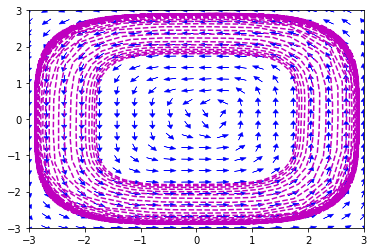

Iteration 0141 | Total Loss 10.161817
Iteration 0142 | Total Loss 10.022953
Iteration 0143 | Total Loss 9.950286
Iteration 0144 | Total Loss 9.811658
Iteration 0145 | Total Loss 9.739352
Iteration 0146 | Total Loss 9.600941
Iteration 0147 | Total Loss 9.528575
Iteration 0148 | Total Loss 9.390810
Iteration 0149 | Total Loss 9.318370
Iteration 0150 | Total Loss 9.182022


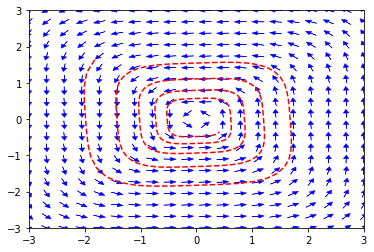

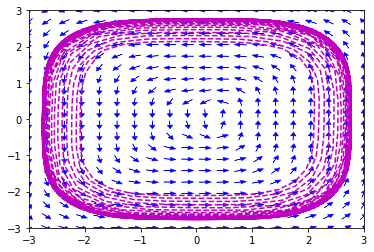

Iteration 0151 | Total Loss 9.109838
Iteration 0152 | Total Loss 8.975847
Iteration 0153 | Total Loss 8.904467
Iteration 0154 | Total Loss 8.773778
Iteration 0155 | Total Loss 8.703830
Iteration 0156 | Total Loss 8.577268
Iteration 0157 | Total Loss 8.509351
Iteration 0158 | Total Loss 8.387540
Iteration 0159 | Total Loss 8.322124
Iteration 0160 | Total Loss 8.205462


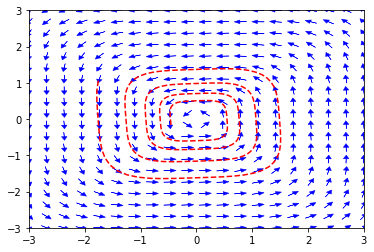

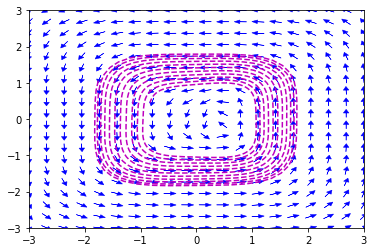

Iteration 0161 | Total Loss 8.142810
Iteration 0162 | Total Loss 8.031454
Iteration 0163 | Total Loss 7.971522
Iteration 0164 | Total Loss 7.865363
Iteration 0165 | Total Loss 7.807644
Iteration 0166 | Total Loss 7.706249
Iteration 0167 | Total Loss 7.649615
Iteration 0168 | Total Loss 7.552180
Iteration 0169 | Total Loss 7.494821
Iteration 0170 | Total Loss 7.400238


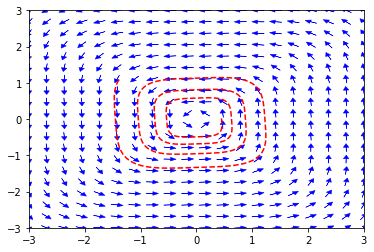

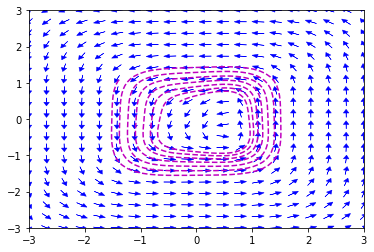

Iteration 0171 | Total Loss 7.339963
Iteration 0172 | Total Loss 7.247035
Iteration 0173 | Total Loss 7.182080
Iteration 0174 | Total Loss 7.089949
Iteration 0175 | Total Loss 7.019887
Iteration 0176 | Total Loss 6.928497
Iteration 0177 | Total Loss 6.854620
Iteration 0178 | Total Loss 6.764845
Iteration 0179 | Total Loss 6.689652
Iteration 0180 | Total Loss 6.602958


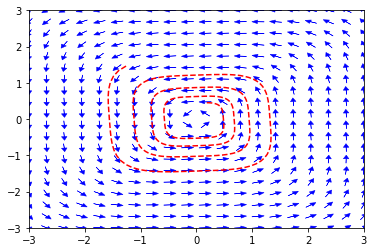

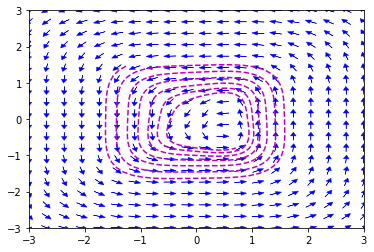

Iteration 0181 | Total Loss 6.529262
Iteration 0182 | Total Loss 6.447145
Iteration 0183 | Total Loss 6.377337
Iteration 0184 | Total Loss 6.300928
Iteration 0185 | Total Loss 6.236692
Iteration 0186 | Total Loss 6.166599
Iteration 0187 | Total Loss 6.108944
Iteration 0188 | Total Loss 6.045278
Iteration 0189 | Total Loss 5.994721
Iteration 0190 | Total Loss 5.937198


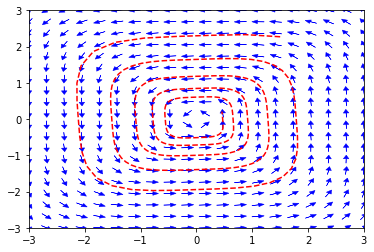

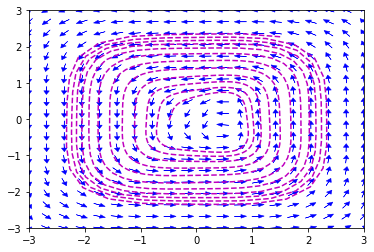

Iteration 0191 | Total Loss 5.894003
Iteration 0192 | Total Loss 5.842137
Iteration 0193 | Total Loss 5.806696
Iteration 0194 | Total Loss 5.760294
Iteration 0195 | Total Loss 5.734135
Iteration 0196 | Total Loss 5.694963
Iteration 0197 | Total Loss 5.683946
Iteration 0198 | Total Loss 5.661593
Iteration 0199 | Total Loss 5.687062
Iteration 0200 | Total Loss 5.717924


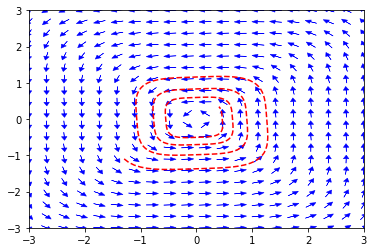

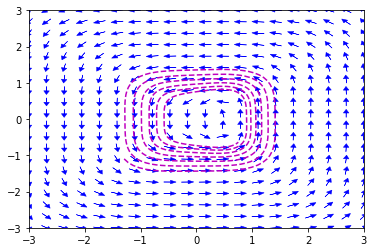

Iteration 0201 | Total Loss 5.851381
Iteration 0202 | Total Loss 6.024926
Iteration 0203 | Total Loss 6.397479
Iteration 0204 | Total Loss 6.595588
Iteration 0205 | Total Loss 6.861139
Iteration 0206 | Total Loss 6.485442
Iteration 0207 | Total Loss 6.154772
Iteration 0208 | Total Loss 5.661882
Iteration 0209 | Total Loss 5.334580
Iteration 0210 | Total Loss 5.067289


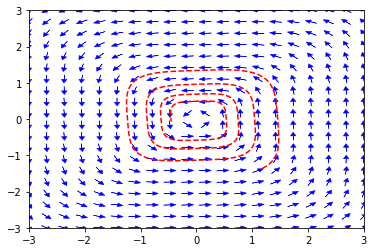

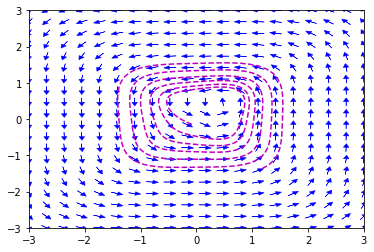

Iteration 0211 | Total Loss 4.915500
Iteration 0212 | Total Loss 4.808697
Iteration 0213 | Total Loss 4.776242
Iteration 0214 | Total Loss 4.757919
Iteration 0215 | Total Loss 4.800267
Iteration 0216 | Total Loss 4.796627
Iteration 0217 | Total Loss 4.848271
Iteration 0218 | Total Loss 4.787367
Iteration 0219 | Total Loss 4.789269
Iteration 0220 | Total Loss 4.679492


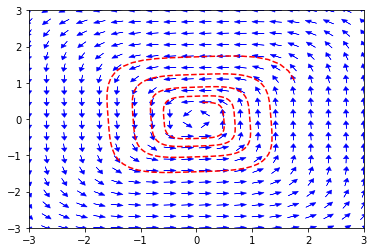

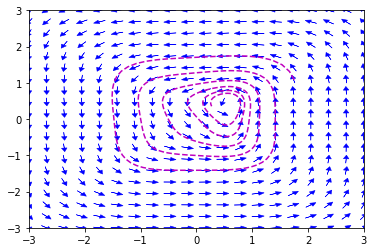

Iteration 0221 | Total Loss 4.635568
Iteration 0222 | Total Loss 4.520517
Iteration 0223 | Total Loss 4.463994
Iteration 0224 | Total Loss 4.370911
Iteration 0225 | Total Loss 4.337987
Iteration 0226 | Total Loss 4.282373
Iteration 0227 | Total Loss 4.308032
Iteration 0228 | Total Loss 4.286362
Iteration 0229 | Total Loss 4.387087
Iteration 0230 | Total Loss 4.345245


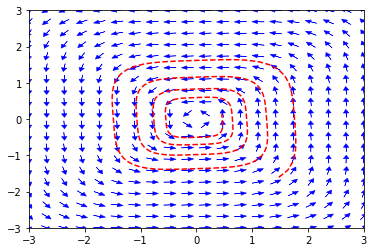

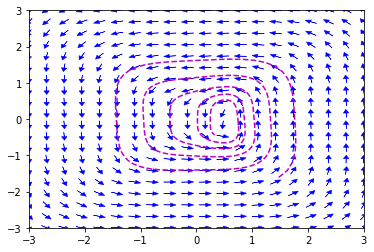

Iteration 0231 | Total Loss 4.475734
Iteration 0232 | Total Loss 4.344047
Iteration 0233 | Total Loss 4.433404
Iteration 0234 | Total Loss 4.236747
Iteration 0235 | Total Loss 4.282532
Iteration 0236 | Total Loss 4.090950
Iteration 0237 | Total Loss 4.129322
Iteration 0238 | Total Loss 3.973835
Iteration 0239 | Total Loss 4.029627
Iteration 0240 | Total Loss 3.909816


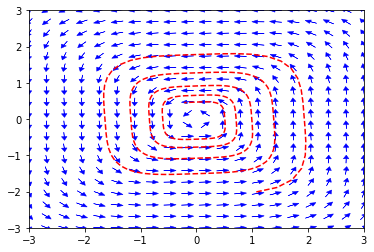

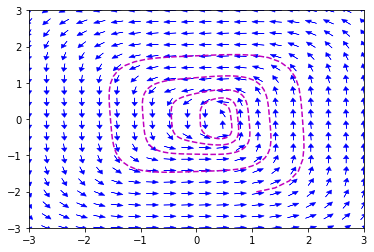

Iteration 0241 | Total Loss 3.993702
Iteration 0242 | Total Loss 3.900557
Iteration 0243 | Total Loss 4.016035
Iteration 0244 | Total Loss 3.941022
Iteration 0245 | Total Loss 4.087263
Iteration 0246 | Total Loss 4.030892
Iteration 0247 | Total Loss 4.213049
Iteration 0248 | Total Loss 4.205269
Iteration 0249 | Total Loss 4.450803
Iteration 0250 | Total Loss 4.542456


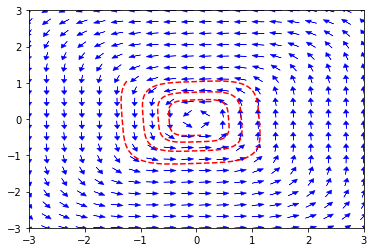

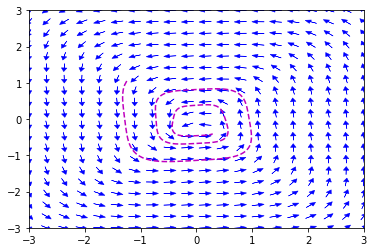

Iteration 0251 | Total Loss 4.847634
Iteration 0252 | Total Loss 4.973010
Iteration 0253 | Total Loss 5.197049
Iteration 0254 | Total Loss 5.060931
Iteration 0255 | Total Loss 5.073006
Iteration 0256 | Total Loss 4.586910
Iteration 0257 | Total Loss 4.448848
Iteration 0258 | Total Loss 3.961589
Iteration 0259 | Total Loss 3.820831
Iteration 0260 | Total Loss 3.506308


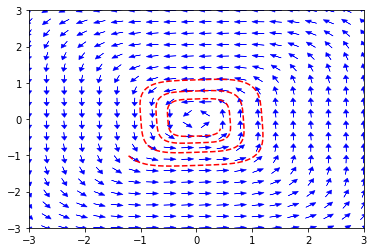

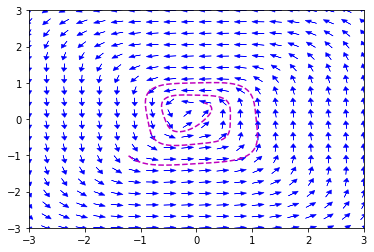

Iteration 0261 | Total Loss 3.420482
Iteration 0262 | Total Loss 3.240483
Iteration 0263 | Total Loss 3.209120
Iteration 0264 | Total Loss 3.108358
Iteration 0265 | Total Loss 3.130910
Iteration 0266 | Total Loss 3.079027
Iteration 0267 | Total Loss 3.172589
Iteration 0268 | Total Loss 3.144679
Iteration 0269 | Total Loss 3.332245
Iteration 0270 | Total Loss 3.273803


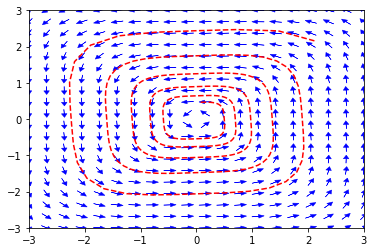

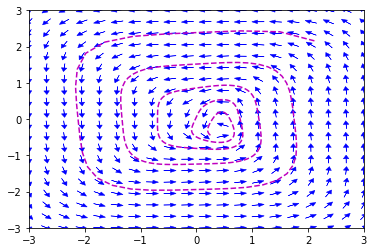

Iteration 0271 | Total Loss 3.540060
Iteration 0272 | Total Loss 3.384536
Iteration 0273 | Total Loss 3.671734
Iteration 0274 | Total Loss 3.420545
Iteration 0275 | Total Loss 3.686186
Iteration 0276 | Total Loss 3.403672
Iteration 0277 | Total Loss 3.647371
Iteration 0278 | Total Loss 3.404643
Iteration 0279 | Total Loss 3.671667
Iteration 0280 | Total Loss 3.487135


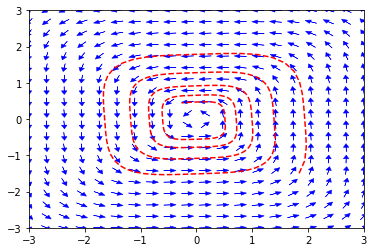

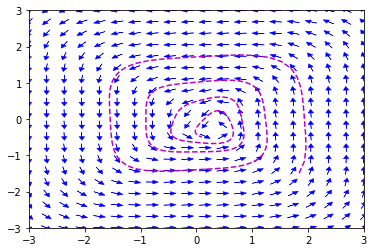

Iteration 0281 | Total Loss 3.823896
Iteration 0282 | Total Loss 3.588639
Iteration 0283 | Total Loss 3.921901
Iteration 0284 | Total Loss 3.518073
Iteration 0285 | Total Loss 3.716528
Iteration 0286 | Total Loss 3.285535
Iteration 0287 | Total Loss 3.373680
Iteration 0288 | Total Loss 3.057026
Iteration 0289 | Total Loss 3.112372
Iteration 0290 | Total Loss 2.914600


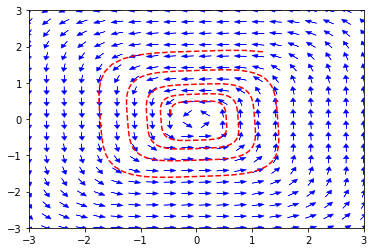

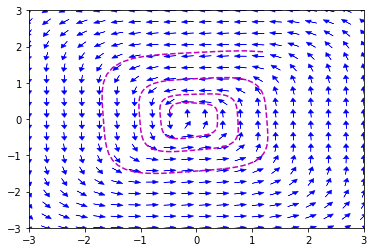

Iteration 0291 | Total Loss 2.983804
Iteration 0292 | Total Loss 2.888740
Iteration 0293 | Total Loss 3.014611
Iteration 0294 | Total Loss 3.056141
Iteration 0295 | Total Loss 3.316848
Iteration 0296 | Total Loss 3.616842
Iteration 0297 | Total Loss 4.117131
Iteration 0298 | Total Loss 4.708531
Iteration 0299 | Total Loss 4.957367
Iteration 0300 | Total Loss 4.810528


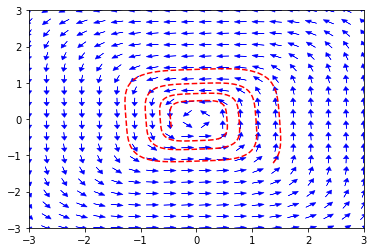

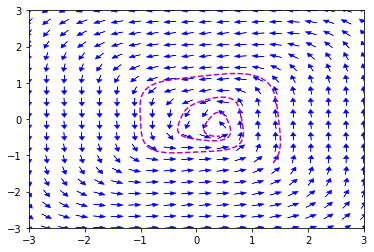

Iteration 0301 | Total Loss 4.101480
Iteration 0302 | Total Loss 3.481435
Iteration 0303 | Total Loss 3.057928
Iteration 0304 | Total Loss 2.748901
Iteration 0305 | Total Loss 2.617703
Iteration 0306 | Total Loss 2.483859
Iteration 0307 | Total Loss 2.472779
Iteration 0308 | Total Loss 2.411635
Iteration 0309 | Total Loss 2.472337
Iteration 0310 | Total Loss 2.446904


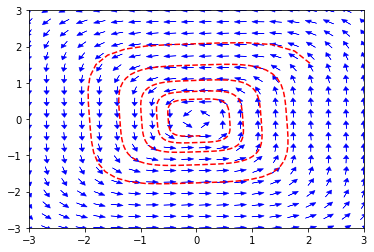

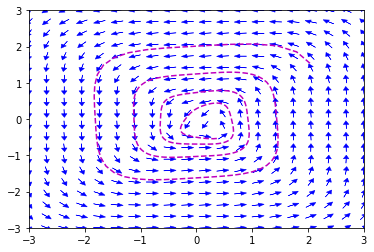

Iteration 0311 | Total Loss 2.578357
Iteration 0312 | Total Loss 2.565827
Iteration 0313 | Total Loss 2.776170
Iteration 0314 | Total Loss 2.739130
Iteration 0315 | Total Loss 3.014285
Iteration 0316 | Total Loss 2.896118
Iteration 0317 | Total Loss 3.185398
Iteration 0318 | Total Loss 2.960796
Iteration 0319 | Total Loss 3.225277
Iteration 0320 | Total Loss 2.949334


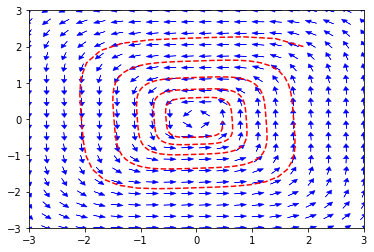

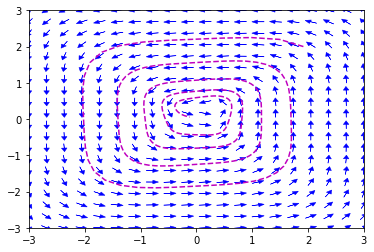

Iteration 0321 | Total Loss 3.217071
Iteration 0322 | Total Loss 2.959381
Iteration 0323 | Total Loss 3.272353
Iteration 0324 | Total Loss 3.016531
Iteration 0325 | Total Loss 3.322173
Iteration 0326 | Total Loss 3.003002
Iteration 0327 | Total Loss 3.199214
Iteration 0328 | Total Loss 2.842266
Iteration 0329 | Total Loss 2.924752
Iteration 0330 | Total Loss 2.613859


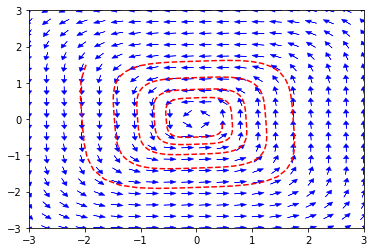

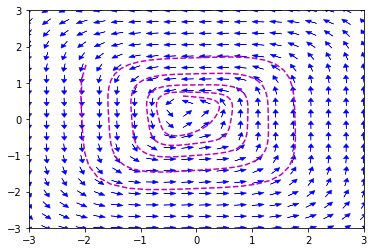

Iteration 0331 | Total Loss 2.645982
Iteration 0332 | Total Loss 2.418335
Iteration 0333 | Total Loss 2.447080
Iteration 0334 | Total Loss 2.295874
Iteration 0335 | Total Loss 2.343509
Iteration 0336 | Total Loss 2.258998
Iteration 0337 | Total Loss 2.346451
Iteration 0338 | Total Loss 2.342727
Iteration 0339 | Total Loss 2.512043
Iteration 0340 | Total Loss 2.641018


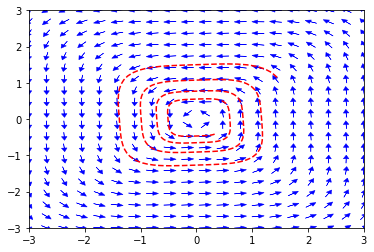

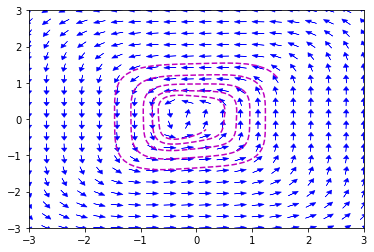

Iteration 0341 | Total Loss 2.947825
Iteration 0342 | Total Loss 3.239116
Iteration 0343 | Total Loss 3.602523
Iteration 0344 | Total Loss 3.805940
Iteration 0345 | Total Loss 3.808915
Iteration 0346 | Total Loss 3.533537
Iteration 0347 | Total Loss 3.208476
Iteration 0348 | Total Loss 2.831476
Iteration 0349 | Total Loss 2.679870
Iteration 0350 | Total Loss 2.485662


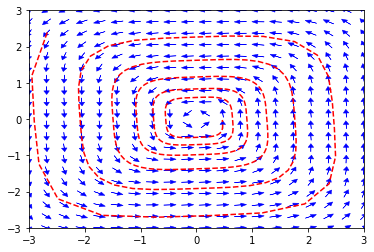

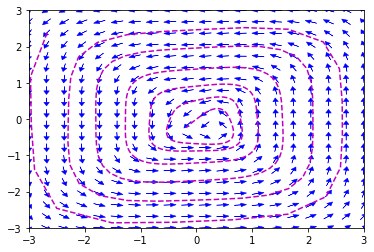

Iteration 0351 | Total Loss 2.536784
Iteration 0352 | Total Loss 2.450350
Iteration 0353 | Total Loss 2.596047
Iteration 0354 | Total Loss 2.514849
Iteration 0355 | Total Loss 2.653717
Iteration 0356 | Total Loss 2.528558
Iteration 0357 | Total Loss 2.625177
Iteration 0358 | Total Loss 2.499445
Iteration 0359 | Total Loss 2.623106
Iteration 0360 | Total Loss 2.555578


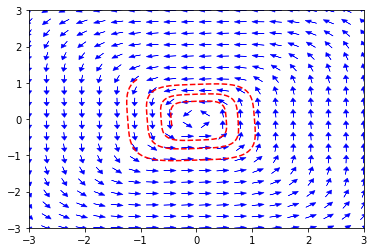

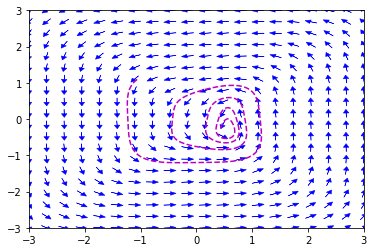

Iteration 0361 | Total Loss 2.778577
Iteration 0362 | Total Loss 2.744634
Iteration 0363 | Total Loss 3.012528
Iteration 0364 | Total Loss 2.919242
Iteration 0365 | Total Loss 3.064227
Iteration 0366 | Total Loss 2.879126
Iteration 0367 | Total Loss 2.855837
Iteration 0368 | Total Loss 2.657969
Iteration 0369 | Total Loss 2.590307
Iteration 0370 | Total Loss 2.447445


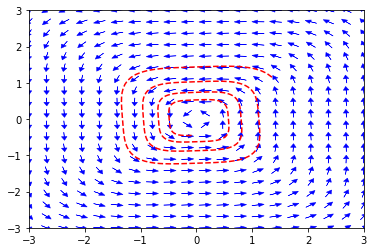

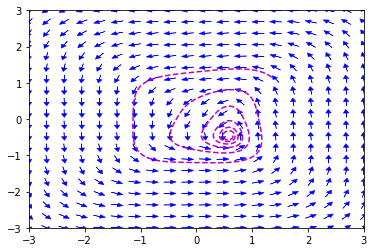

Iteration 0371 | Total Loss 2.415776
Iteration 0372 | Total Loss 2.319749
Iteration 0373 | Total Loss 2.311406
Iteration 0374 | Total Loss 2.236204
Iteration 0375 | Total Loss 2.221825
Iteration 0376 | Total Loss 2.170011
Iteration 0377 | Total Loss 2.147983
Iteration 0378 | Total Loss 2.133691
Iteration 0379 | Total Loss 2.119256
Iteration 0380 | Total Loss 2.144323


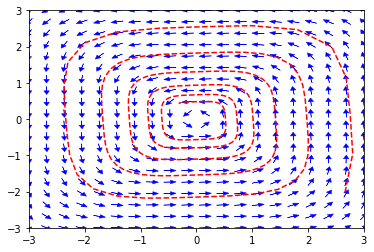

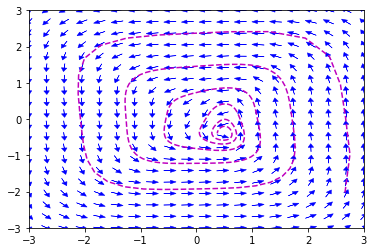

Iteration 0381 | Total Loss 2.157190
Iteration 0382 | Total Loss 2.218726
Iteration 0383 | Total Loss 2.286750
Iteration 0384 | Total Loss 2.391722
Iteration 0385 | Total Loss 2.539681
Iteration 0386 | Total Loss 2.680274
Iteration 0387 | Total Loss 2.860848
Iteration 0388 | Total Loss 2.932536
Iteration 0389 | Total Loss 2.978652
Iteration 0390 | Total Loss 2.852606


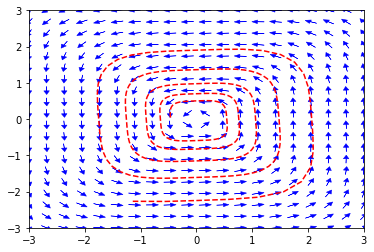

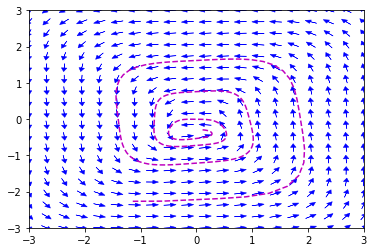

Iteration 0391 | Total Loss 2.712764
Iteration 0392 | Total Loss 2.486211
Iteration 0393 | Total Loss 2.326311
Iteration 0394 | Total Loss 2.157539
Iteration 0395 | Total Loss 2.089572
Iteration 0396 | Total Loss 2.014038
Iteration 0397 | Total Loss 2.057856
Iteration 0398 | Total Loss 2.044798
Iteration 0399 | Total Loss 2.193344
Iteration 0400 | Total Loss 2.171868


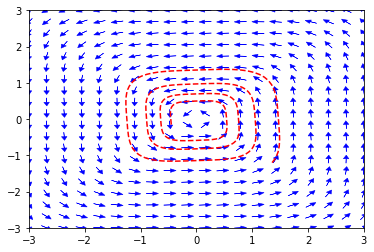

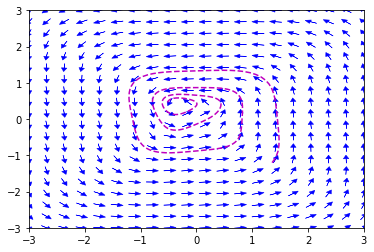

Iteration 0401 | Total Loss 2.379868
Iteration 0402 | Total Loss 2.250627
Iteration 0403 | Total Loss 2.423507
Iteration 0404 | Total Loss 2.166176
Iteration 0405 | Total Loss 2.251075
Iteration 0406 | Total Loss 1.983944
Iteration 0407 | Total Loss 2.038051
Iteration 0408 | Total Loss 1.883215
Iteration 0409 | Total Loss 2.009727
Iteration 0410 | Total Loss 2.009443


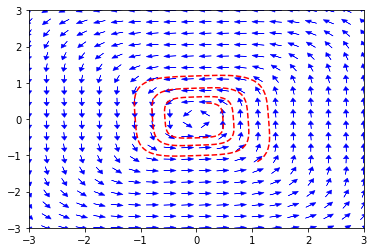

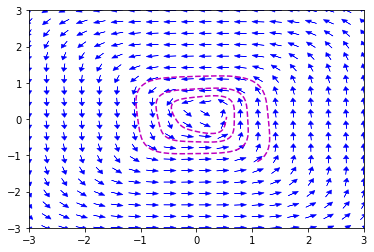

Iteration 0411 | Total Loss 2.277927
Iteration 0412 | Total Loss 2.353786
Iteration 0413 | Total Loss 2.685430
Iteration 0414 | Total Loss 2.666754
Iteration 0415 | Total Loss 2.938288
Iteration 0416 | Total Loss 2.891419
Iteration 0417 | Total Loss 3.158900
Iteration 0418 | Total Loss 3.196621
Iteration 0419 | Total Loss 3.318634
Iteration 0420 | Total Loss 3.244191


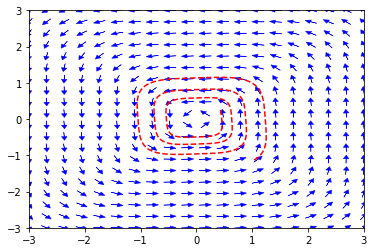

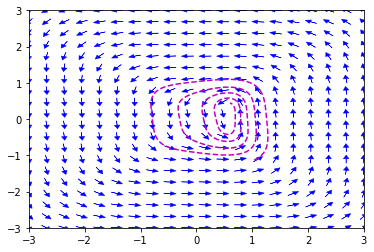

Iteration 0421 | Total Loss 3.010627
Iteration 0422 | Total Loss 2.792943
Iteration 0423 | Total Loss 2.443250
Iteration 0424 | Total Loss 2.251234
Iteration 0425 | Total Loss 1.978853
Iteration 0426 | Total Loss 1.848500
Iteration 0427 | Total Loss 1.670478
Iteration 0428 | Total Loss 1.584748
Iteration 0429 | Total Loss 1.478568
Iteration 0430 | Total Loss 1.424976


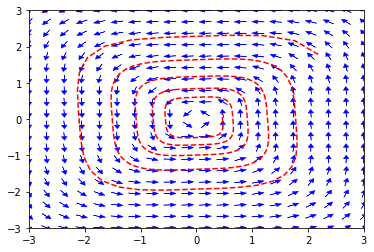

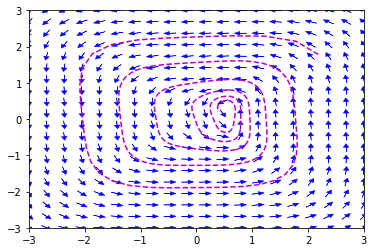

Iteration 0431 | Total Loss 1.372033
Iteration 0432 | Total Loss 1.344858
Iteration 0433 | Total Loss 1.339373
Iteration 0434 | Total Loss 1.339436
Iteration 0435 | Total Loss 1.393653
Iteration 0436 | Total Loss 1.427853
Iteration 0437 | Total Loss 1.576757
Iteration 0438 | Total Loss 1.644410
Iteration 0439 | Total Loss 1.927849
Iteration 0440 | Total Loss 1.971521


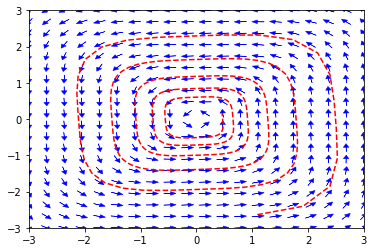

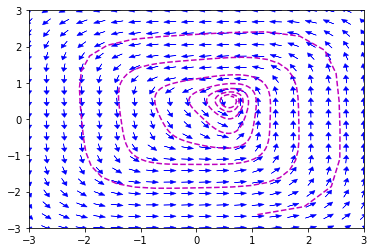

Iteration 0441 | Total Loss 2.350247
Iteration 0442 | Total Loss 2.244033
Iteration 0443 | Total Loss 2.562557
Iteration 0444 | Total Loss 2.325015
Iteration 0445 | Total Loss 2.527877
Iteration 0446 | Total Loss 2.397406
Iteration 0447 | Total Loss 2.605730
Iteration 0448 | Total Loss 2.739253
Iteration 0449 | Total Loss 2.971393
Iteration 0450 | Total Loss 3.195741


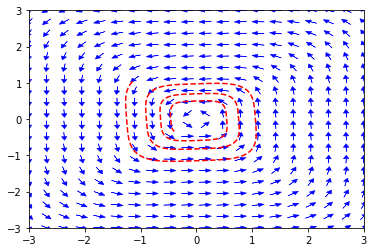

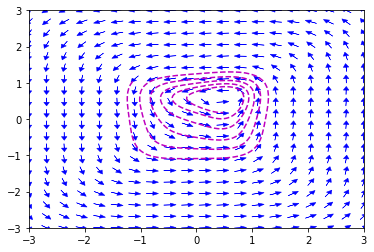

Iteration 0451 | Total Loss 3.140850
Iteration 0452 | Total Loss 3.094603
Iteration 0453 | Total Loss 2.722753
Iteration 0454 | Total Loss 2.543873
Iteration 0455 | Total Loss 2.227429
Iteration 0456 | Total Loss 2.137502
Iteration 0457 | Total Loss 1.952330
Iteration 0458 | Total Loss 1.936665
Iteration 0459 | Total Loss 1.820874
Iteration 0460 | Total Loss 1.830495


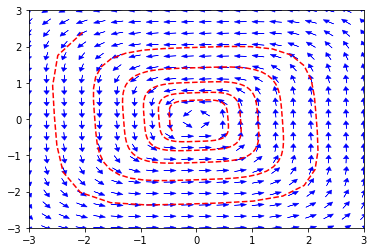

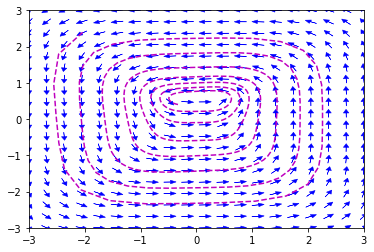

Iteration 0461 | Total Loss 1.748871
Iteration 0462 | Total Loss 1.763196
Iteration 0463 | Total Loss 1.705856
Iteration 0464 | Total Loss 1.722136
Iteration 0465 | Total Loss 1.688605
Iteration 0466 | Total Loss 1.711213
Iteration 0467 | Total Loss 1.704587
Iteration 0468 | Total Loss 1.741579
Iteration 0469 | Total Loss 1.768333
Iteration 0470 | Total Loss 1.832964


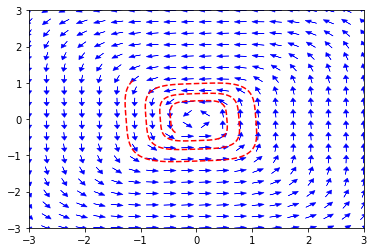

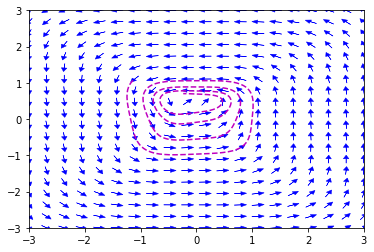

Iteration 0471 | Total Loss 1.904260
Iteration 0472 | Total Loss 2.018260
Iteration 0473 | Total Loss 2.146314
Iteration 0474 | Total Loss 2.334316
Iteration 0475 | Total Loss 2.506954
Iteration 0476 | Total Loss 2.753900
Iteration 0477 | Total Loss 2.882826
Iteration 0478 | Total Loss 3.066021
Iteration 0479 | Total Loss 3.021064
Iteration 0480 | Total Loss 2.995265


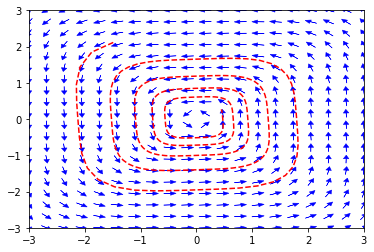

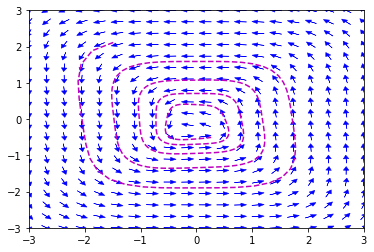

Iteration 0481 | Total Loss 2.786502
Iteration 0482 | Total Loss 2.592633
Iteration 0483 | Total Loss 2.363076
Iteration 0484 | Total Loss 2.148693
Iteration 0485 | Total Loss 1.989512
Iteration 0486 | Total Loss 1.828205
Iteration 0487 | Total Loss 1.746321
Iteration 0488 | Total Loss 1.640632
Iteration 0489 | Total Loss 1.615970
Iteration 0490 | Total Loss 1.549403


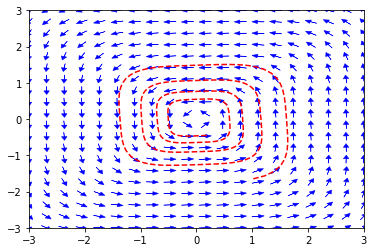

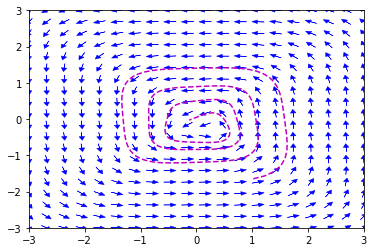

Iteration 0491 | Total Loss 1.565797
Iteration 0492 | Total Loss 1.523853
Iteration 0493 | Total Loss 1.576060
Iteration 0494 | Total Loss 1.549606
Iteration 0495 | Total Loss 1.643348
Iteration 0496 | Total Loss 1.623761
Iteration 0497 | Total Loss 1.765528
Iteration 0498 | Total Loss 1.730562
Iteration 0499 | Total Loss 1.899526
Iteration 0500 | Total Loss 1.811505


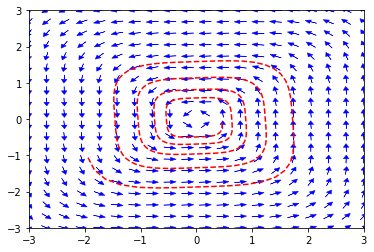

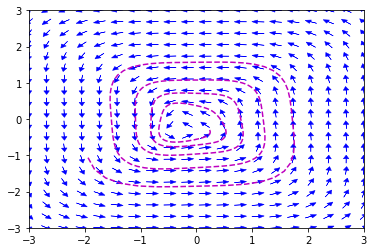

Iteration 0501 | Total Loss 1.952978
Iteration 0502 | Total Loss 1.805209
Iteration 0503 | Total Loss 1.892688
Iteration 0504 | Total Loss 1.729171
Iteration 0505 | Total Loss 1.788996
Iteration 0506 | Total Loss 1.645279
Iteration 0507 | Total Loss 1.702791
Iteration 0508 | Total Loss 1.591342
Iteration 0509 | Total Loss 1.655580
Iteration 0510 | Total Loss 1.603597


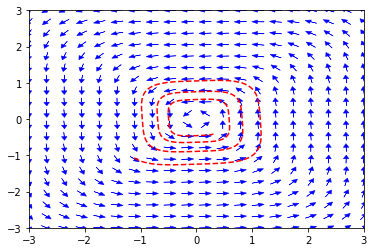

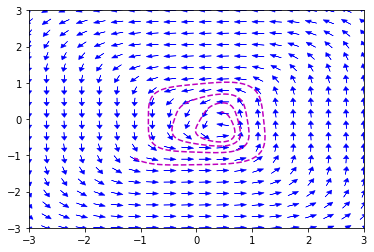

Iteration 0511 | Total Loss 1.692100
Iteration 0512 | Total Loss 1.766382
Iteration 0513 | Total Loss 1.913105
Iteration 0514 | Total Loss 2.224047
Iteration 0515 | Total Loss 2.387792
Iteration 0516 | Total Loss 2.899246
Iteration 0517 | Total Loss 2.681607
Iteration 0518 | Total Loss 2.873455
Iteration 0519 | Total Loss 2.222188
Iteration 0520 | Total Loss 2.061232


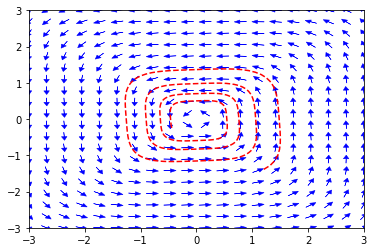

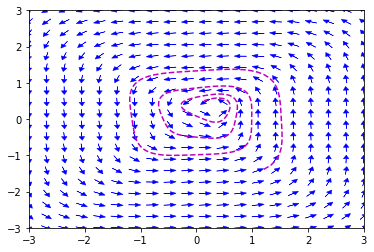

Iteration 0521 | Total Loss 1.604858
Iteration 0522 | Total Loss 1.462247
Iteration 0523 | Total Loss 1.273630
Iteration 0524 | Total Loss 1.217852
Iteration 0525 | Total Loss 1.170172
Iteration 0526 | Total Loss 1.171248
Iteration 0527 | Total Loss 1.197487
Iteration 0528 | Total Loss 1.227788
Iteration 0529 | Total Loss 1.295003
Iteration 0530 | Total Loss 1.326839


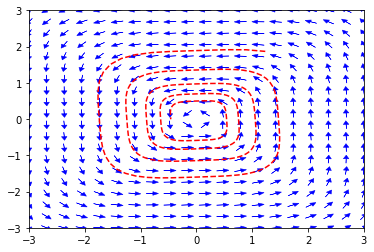

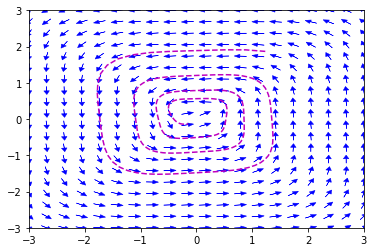

Iteration 0531 | Total Loss 1.406368
Iteration 0532 | Total Loss 1.413213
Iteration 0533 | Total Loss 1.482258
Iteration 0534 | Total Loss 1.459512
Iteration 0535 | Total Loss 1.518851
Iteration 0536 | Total Loss 1.493200
Iteration 0537 | Total Loss 1.563822
Iteration 0538 | Total Loss 1.567656
Iteration 0539 | Total Loss 1.658972
Iteration 0540 | Total Loss 1.692552


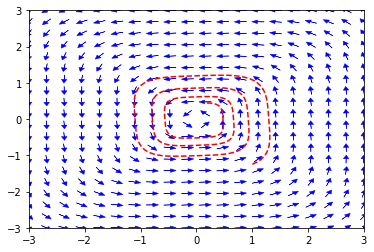

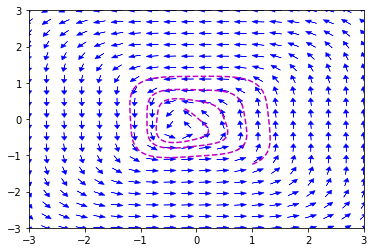

Iteration 0541 | Total Loss 1.772820
Iteration 0542 | Total Loss 1.790675
Iteration 0543 | Total Loss 1.807368
Iteration 0544 | Total Loss 1.767537
Iteration 0545 | Total Loss 1.721424
Iteration 0546 | Total Loss 1.648295
Iteration 0547 | Total Loss 1.606828
Iteration 0548 | Total Loss 1.562576
Iteration 0549 | Total Loss 1.593840
Iteration 0550 | Total Loss 1.608940


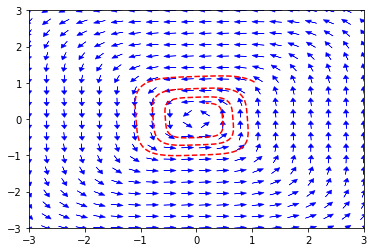

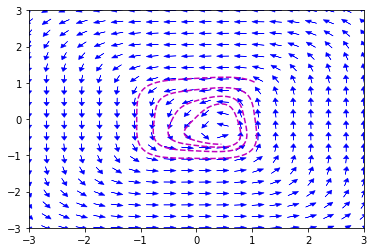

Iteration 0551 | Total Loss 1.730237
Iteration 0552 | Total Loss 1.773349
Iteration 0553 | Total Loss 1.943883
Iteration 0554 | Total Loss 1.998243
Iteration 0555 | Total Loss 2.213940
Iteration 0556 | Total Loss 2.401357
Iteration 0557 | Total Loss 2.704259
Iteration 0558 | Total Loss 3.079700
Iteration 0559 | Total Loss 3.245342
Iteration 0560 | Total Loss 3.432274


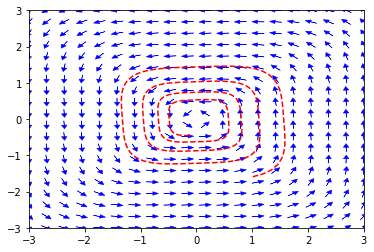

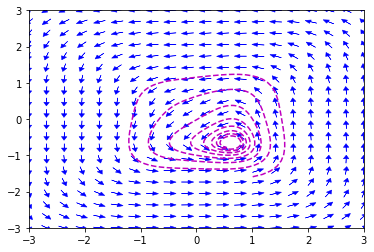

Iteration 0561 | Total Loss 3.189191
Iteration 0562 | Total Loss 2.946151
Iteration 0563 | Total Loss 2.615205
Iteration 0564 | Total Loss 2.261546
Iteration 0565 | Total Loss 2.095847
Iteration 0566 | Total Loss 1.836951
Iteration 0567 | Total Loss 1.802423
Iteration 0568 | Total Loss 1.636746
Iteration 0569 | Total Loss 1.666564
Iteration 0570 | Total Loss 1.555093


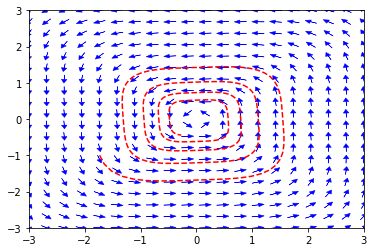

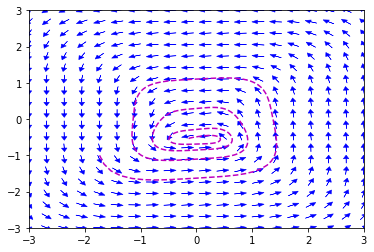

Iteration 0571 | Total Loss 1.610920
Iteration 0572 | Total Loss 1.529948
Iteration 0573 | Total Loss 1.593935
Iteration 0574 | Total Loss 1.539122
Iteration 0575 | Total Loss 1.607575
Iteration 0576 | Total Loss 1.584856
Iteration 0577 | Total Loss 1.661149
Iteration 0578 | Total Loss 1.671393
Iteration 0579 | Total Loss 1.754391
Iteration 0580 | Total Loss 1.779118


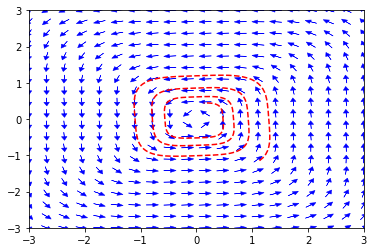

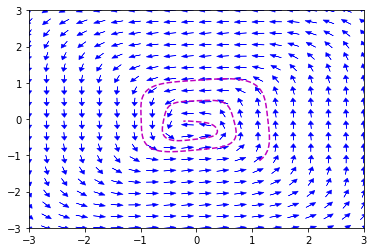

Iteration 0581 | Total Loss 1.853577
Iteration 0582 | Total Loss 1.853884
Iteration 0583 | Total Loss 1.897528
Iteration 0584 | Total Loss 1.839516
Iteration 0585 | Total Loss 1.847693
Iteration 0586 | Total Loss 1.732867
Iteration 0587 | Total Loss 1.724905
Iteration 0588 | Total Loss 1.581585
Iteration 0589 | Total Loss 1.577037
Iteration 0590 | Total Loss 1.431314


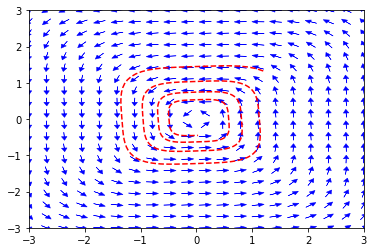

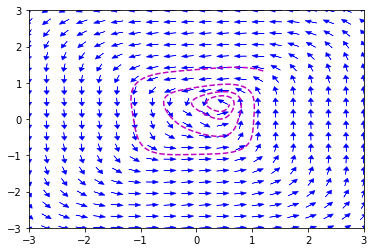

Iteration 0591 | Total Loss 1.435852
Iteration 0592 | Total Loss 1.302616
Iteration 0593 | Total Loss 1.315116
Iteration 0594 | Total Loss 1.202929
Iteration 0595 | Total Loss 1.224164
Iteration 0596 | Total Loss 1.139146
Iteration 0597 | Total Loss 1.174643
Iteration 0598 | Total Loss 1.123406
Iteration 0599 | Total Loss 1.185018
Iteration 0600 | Total Loss 1.179919


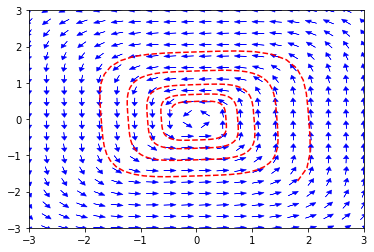

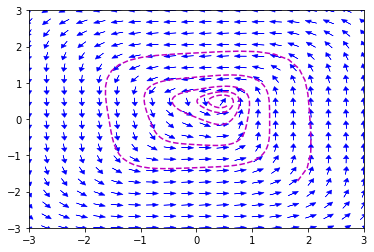

Iteration 0601 | Total Loss 1.290213
Iteration 0602 | Total Loss 1.357621
Iteration 0603 | Total Loss 1.554496
Iteration 0604 | Total Loss 1.737784
Iteration 0605 | Total Loss 2.051648
Iteration 0606 | Total Loss 2.363260
Iteration 0607 | Total Loss 2.689818
Iteration 0608 | Total Loss 2.960954
Iteration 0609 | Total Loss 2.958381
Iteration 0610 | Total Loss 2.916655


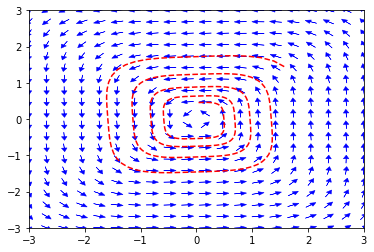

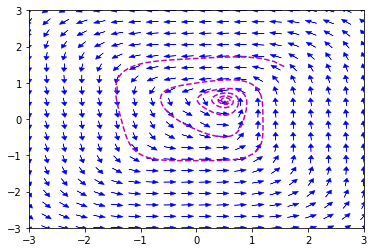

Iteration 0611 | Total Loss 2.524659
Iteration 0612 | Total Loss 2.269232
Iteration 0613 | Total Loss 1.884289
Iteration 0614 | Total Loss 1.664081
Iteration 0615 | Total Loss 1.458527
Iteration 0616 | Total Loss 1.337792
Iteration 0617 | Total Loss 1.273785
Iteration 0618 | Total Loss 1.238163
Iteration 0619 | Total Loss 1.273377
Iteration 0620 | Total Loss 1.314741


KeyboardInterrupt: 

In [15]:
if __name__ == '__main__':
    
    #ii = 0
    
    Y = torch.linspace(-3,3,20)
    X = torch.linspace(-3,3,50)
    h = 0.22
    
    func = ODEFunc()
    optimizer = optim.RMSprop(func.parameters())          #this is an optimizer designed to update parameters
    end = time.time()                                     #usually people use SGD but this is a mini-batch approach
                                                          #http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf
    #RunningAvgMeter Objects
    time_meter = RunningAverageMeter(0.97)
    loss_meter = RunningAverageMeter(0.97)
    
    #TRAINING
    for itr in range(1, niters+1):
        #DEFINE TRUE Y WITH RANDOM IVP
        #initial conditions; requires 2D tensor
        true_y0 = torch.tensor([[random(),random()]])
        with torch.no_grad(): #no_grad disables gradient finding when true_y is defined
            #print(torch.mm(true_y0**3,true_A))
            true_y = odeint(Lambda(),true_y0, t, method='adams') 
            #true_y is the solved ODE defined in Lambda
            #odeint only takes a function from nn.Module >> implications? see solver comparision Jupyter
            #it uses Lambda to provide the function to go solve the IVP given true_y0 with the ODE solver on t
            #----------------------------------------------------------
            trueSl = getSlopesTorch(X.numpy(),X.numpy(),Lambda())

        
        optimizer.zero_grad() #set gradients to zero/ not computed
        
        #batch_y0, batch_t, batch_y = get_batch()
        #feeds odeint the ODEBlock, a set of y values based on random t values and the first ten values of t
        #pred_y = odeint(func, batch_y0, batch_t)
        #deviates from usual Loss of mean squared difference but sum in both cases is positive
        #print(pred_y.detach(),batch_y)
        #---------------------------------------
        predSl = getSlopesTorch(X.numpy(),X.numpy(),func)
        
        #loss = torch.mean(torch.abs(pred_y-batch_y)**2) #ask Ivan about predY-bY, also this returns a number
        #--------------------------------------------------
        loss = torch.mean(torch.abs(predSl-trueSl)**2)
        
        loss.backward() #backpropogation
        optimizer.step() #gradient descent and update parameters
    
        #Update time and loss meters
        time_meter.update(time.time()-end) #takes in time difference to establish velocity see RMS method details
        loss_meter.update(loss.item()) #the loss itself is a delta / change
        
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            #loss = torch.mean(torch.abs(pred_y-true_y)**2)
            #-------------------------------------------------
            predSl = getSlopesTorch(X.numpy(),X.numpy(),func)
            loss = torch.mean(torch.abs(predSl-trueSl)**2)
            
            print('Iteration {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
        
            if itr % test_freq == 0:
                visualize(true_y, pred_y, Y.numpy(), h, func)
                
        end = time.time()